# ロボットビジョン課題 1「画像処理の基礎」

---
<div style="text-align:right;">
<p style="display:inline-block; text-align:left; font-size:20px; line-height:140%;">
<!--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-->
【学生番号】19C1068 <br />
【氏　　名】髙橋 祐樹
<!--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=--=-->
</p>
</div>

---

## 目次

* 提出に関して
* 課題 1-1）「（疑似）現像処理」
* 課題 1-1）解答用紙
* 課題 1-2）「焦点ぼけとカメラぶれの補正」
* 課題 1-2）解答用紙
* 課題 1-3）「パノラマ画像合成」
* 課題 1-3）解答用紙
---


## 【重要】提出に関して
  1. 締め切り：<font color="red">**2020年11月21日（日）23:55**</font>
    * レポート提出は単位取得のための必須要件なので注意すること
    * 締め切り内の再提出は何度でも可能
      <br>
      <br>
  1. 提出形式：
    * 形式：このJupyter notebook を <font color="red">**HTML**</font> 化したものを提出すること（拡張子は「.html」）
    * ファイル名は「<font color="red">**学生番号\_名前\_課題1.html**</font>」とすること（例：19Cxxxx_千葉工花名無し_課題2.html）
    * 提出の際には<font color="red">**上記の学生番号と氏名も編集して**</font>提出すること
    <br>
      <br>
  1. 提出先：[manaba](https://cit.manaba.jp/ct/course_321459_rptadm?action=rptlist)
      <br>
      <br>
  1. 注意事項：
    * 課題に用いる画像を自身で準備した場合は著作権・肖像権的に問題のない，公序良俗に反しないものを用いること
    * 提出されたレポートは<font color="red">**相互の学習のため公開する可能性があり**</font>ますので，第三者に閲覧された際に問題のない画像を用いること．

---
## 課題 1-1）課題「（疑似）現像処理」
  [提供するPGMデータセット](https://www.rsa.it-chiba.ac.jp/lecture/dataset/rawdata/)の中から一つを選択し，自身で作成したプログラムで現像してください．ただし，以下の手順を踏み，それぞれの処理について各処理後の画像を示し，それぞれに施した処理の意図と結果に関する考察を述べること．

### 課題の目的
* ここまでの講義で扱ってきた画像処理の理論を理解しているかの確認
* ここまでの講義で扱ってきたサンプルコードを理解し，必要な関数を用いて上記理論を実装できるかの確認

-----
### 必要なライブラリのインポート
  * 適宜，必要なライブラリを追加してよい

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt 

#-----------------------------------
# 今までの講義で使った関数を格納
#-----------------------------------
from my_script import *

# デモザイキング済みの画像
demosaiced_data = None

---
### PGM ファイルのヘッダ部分のパース

In [2]:
def parse_pgm(fd):
    
    # 16bit pgm（バイナリ）のフォーマット例
    # P5             // P1-P6 改行(\x0A)
    # # comments
    # 4284 2844      // width スペース(\x20) height 改行(\x0A)
    # 65535          //　階調数（2^bit数-1） 改行(\x0A)
    # RGRGRGRG....
    # GBGBGBGB....   // (各色16bitずつ)

    w = 0
    h = 0
    lim = 0
    lines = 0
    count = 0
    wFlag = True
    val = np.array([])

    while True: # 改行コード（0x0A）, スペース（0x20）
        ch = fd.read(1)
        if ch==b'\x23':
            while True:
                ch = fd.read(1)
                if ch==b'\x0A':
                    break
            continue
        elif lines==1:    # 画像の縦横サイズを取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    if wFlag:
                        w += val[i] * pow(10, count-i-1)
                    else:
                        h += val[i] * pow(10, count-i-1)
                wFlag = False
                val = np.array([])
                count = 0
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        elif lines==2:  # センサビット深度の取得
            if ch==b'\x20' or ch==b'\x0A':
                for i in range(count):
                    lim += val[i] * pow(10, count-i-1)
            else:
                num = int(ch)
                val = np.append(val, num)
                count = count + 1
        if ch==b'\x0A':
            lines = lines + 1
        if lines>=3:
            break

    print("(w, h, lim) = ({}, {}, {})".format(w, h, lim))
    
    w = int(w)
    h = int(h)
    lim = int(lim)
    
    return w, h, lim

### デモザイキング関数
  * ひな型として講義で紹介した疑似的なデモザイキング関数を実装
  * 独自で実装を変更してよい

In [3]:
def my_demosaicing(img_path):
    
    # バイナリモードでオープン
    fd = open(img_path, 'rb')
    
    w, h, lim = parse_pgm(fd)
    
    # 階調が255（8ビット）よりも大きい場合は，Big endian で 16 bit ずつ読み込み
    # [エンディアンの参考] https://qiita.com/mski_iksm/items/bb0aa375c952c2d7b91a
    if lim > 255:
        #data = np.fromfile(fd, dtype=np.dtype('>u2'))
        data = np.fromfile(fd, dtype=np.dtype('>H'))
    else:
        data = np.fromfile(fd, dtype=np.dtype('>u1'))
    data = data.astype(float);

    #----------------------------------
    # 以下を独自の実装に変更
    #----------------------------------
    img = np.zeros((h,w,3), dtype=float)
    for v in range(h-1):
        for u in range(w-1):
            i = v * w + u
            if u%2==0 and v%2==0:
                r = data[i]
                g1 = data[i+1]
                g2 = data[i+w]
                b = data[i+w+1]
            elif u%2==1 and v%2==0:
                r = data[i+1]
                g1 = data[i]
                g2 = data[i+w+1]
                b = data[i+w]
            elif u%2==0 and v%2==1:
                r = data[i+w]
                g1 = data[i+w+1]
                g2 = data[i]
                b = data[i+1]
            elif u%2==1 and v%2==1:
                r = data[i+w+1]
                g1 = data[i+w]
                g2 = data[i+1]
                b = data[i]
            img[v,u,0] = r
            img[v,u,1] = (g1+g2)/2.0
            img[v,u,2] = b
    fd.close();
    
    return img, w, h, lim

---
##  課題 1-1）解答用紙

### 1）PGMファイルの読み込みとデモザイキング処理

**【注意】RAWファイルの解像度が大きいため環境によっては処理に時間がかかることがあります**

　→　<font color="red">**処理が重いので処理を繰り返すときは次以降のセルから始めると良い**</font>

In [4]:
#--------------------------------------------
# ここを選択したPGMファイルに変更すること
#--------------------------------------------
img_path = "C:/Users/G_N_R_Axl/Desktop/未ロ/6s/ロボビジョ/photo/img06.pgm".replace('/', os.sep) # ファイル名

# デモザイキングの処理を変更する場合は，上記の my_demosaicing() を改変すること
if demosaiced_data is None:
    demosaiced_data, w, h, lim = my_demosaicing(img_path)

(w, h, lim) = (4608.0, 3072.0, 65535.0)


### matplotib での表示

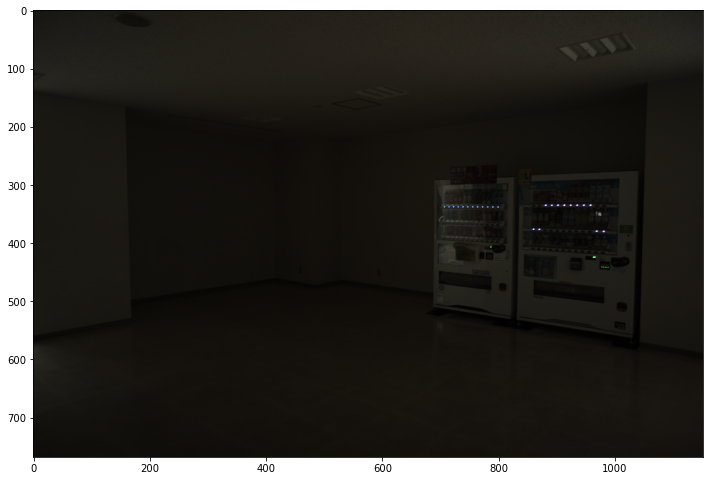

In [5]:
# ここから 8bit 画像（確認用）に変換
R = 255.0 / lim # センサビット数 -> 8bit への等倍変換
demosaiced_data *= R
demosaiced_data = demosaiced_data.astype(np.uint8);

img = cv2.resize(demosaiced_data, (int(w/4), int(h/4)));   # 適当な大きさにリサイズ（ここでは縦横 1/6 に縮小）

plt.figure(figsize=(12, 9))
plt.imshow(img)
plt.show()

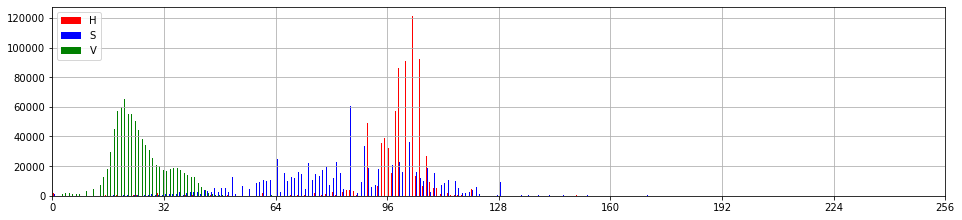

In [6]:
img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# 画像を各色空間のプレーンごとに一次元の配列に成形
r = img[:, :, 2].flatten()
g = img[:, :, 1].flatten()
b = img[:, :, 0].flatten()

y = img_YUV[:, :, 0].flatten()
u = img_YUV[:, :, 1].flatten()
v = img_YUV[:, :, 2].flatten()

hue = img_HSV[:, :, 0].flatten()
saturation = img_HSV[:, :, 1].flatten()
value = img_HSV[:, :, 2].flatten()

bins_range = range(0, 256, 1)       # bins は [0,256)という指定になる（https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html）
xtics_range = range(0, 256 + 1, 32) # 目盛りを256まで表示させたいので 256 + 1 に設定しているだけ

plt.figure(figsize=(16, 16))

# (H,S,V)
plt.subplot(4, 1, 4)
plt.hist((hue, saturation, value), bins=bins_range, color=['r', 'b', 'g'], label=['H', 'S', 'V'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)

plt.show()

----
### 2）画像変換：××の処理（例：コントラスト補正，ガンマ補正，色調補正など）
#### 本処理の狙い
  * 本処理は原画像における〇〇という問題を△△することで補正することを目的としている．
  * そのため，■■という特徴を持った××処理を適用する．

#### 結果と考察
  * 結果と考察を行う

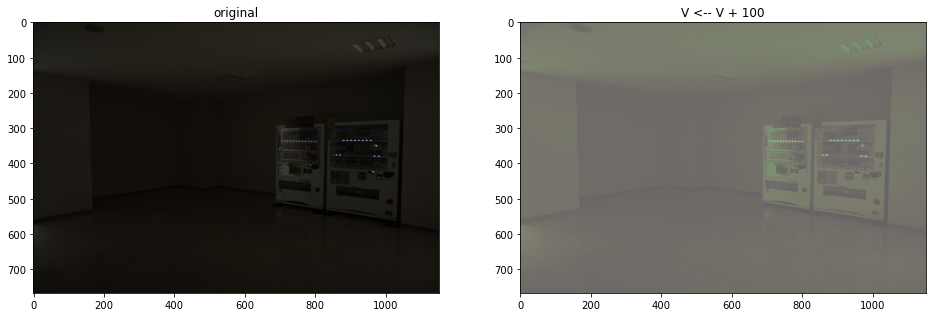

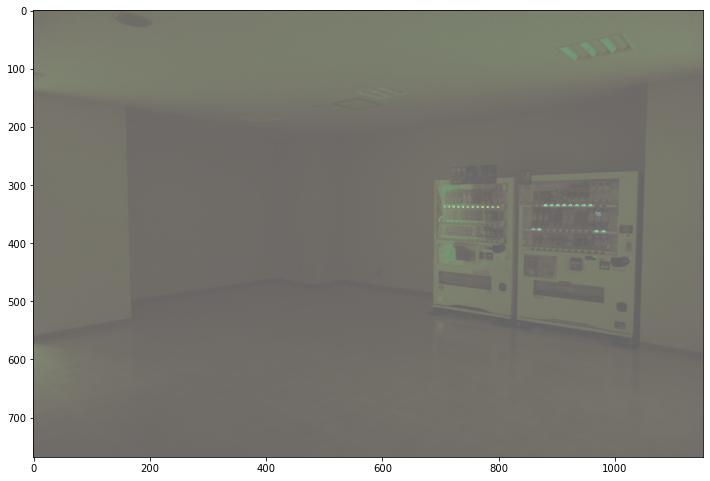

In [7]:
# いったんコピーを取ってから処理を行う
tone_processed_img = img.copy()

# 何かしらの処理を施す
# 明るさ（V）を増してみる
lighted_img_HSV = img.copy()
lighted_img_HSV[:,:,2] = np.minimum(img[:,:,2].astype('uint16') + 100, 255) # V（明度）を増して上限（255）超えたらクリッピング
#lighted_img_HSV[:,:,2] = np.minimum(img_HSV[:,:,2] + 50, 200) # 【注意】これだとうまくいかない（次項：補足の補足を参照）

# 色を HSV から RGB（matplotlibで表示用）に変換
lighted_img_HSV2RGB = cv2.cvtColor(lighted_img_HSV, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(16, 9))

# オリジナル画像の表示
plt.subplot(1, 2, 1)
plt.title("original")
plt.imshow(img)

# V（明度）を増した画像
plt.subplot(1, 2, 2)
plt.title("V <-- V + 100")
plt.imshow(lighted_img_HSV2RGB)

plt.show()

# 結果の提示
plt.figure(figsize=(12, 9))
plt.imshow(lighted_img_HSV2RGB)
plt.show()

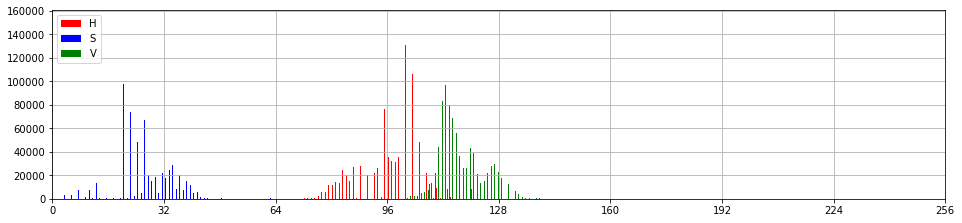

In [8]:
lighted_img_HSV2RGB_YUV = cv2.cvtColor(lighted_img_HSV2RGB, cv2.COLOR_BGR2YUV)
lighted_img_HSV2RGB_HSV = cv2.cvtColor(lighted_img_HSV2RGB, cv2.COLOR_BGR2HSV)

# 画像を各色空間のプレーンごとに一次元の配列に成形
r = lighted_img_HSV2RGB[:, :, 2].flatten()
g = lighted_img_HSV2RGB[:, :, 1].flatten()
b = lighted_img_HSV2RGB[:, :, 0].flatten()

y = lighted_img_HSV2RGB_YUV[:, :, 0].flatten()
u = lighted_img_HSV2RGB_YUV[:, :, 1].flatten()
v = lighted_img_HSV2RGB_YUV[:, :, 2].flatten()

hue = lighted_img_HSV2RGB_HSV[:, :, 0].flatten()
saturation = lighted_img_HSV2RGB_HSV[:, :, 1].flatten()
value = lighted_img_HSV2RGB_HSV[:, :, 2].flatten()

bins_range = range(0, 256, 1)       # bins は [0,256)という指定になる（https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html）
xtics_range = range(0, 256 + 1, 32) # 目盛りを256まで表示させたいので 256 + 1 に設定しているだけ

plt.figure(figsize=(16, 16))

# (H,S,V)
plt.subplot(4, 1, 4)
plt.hist((hue, saturation, value), bins=bins_range, color=['r', 'b', 'g'], label=['H', 'S', 'V'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)

plt.show()

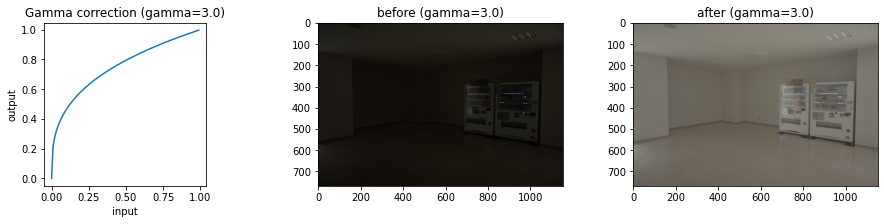

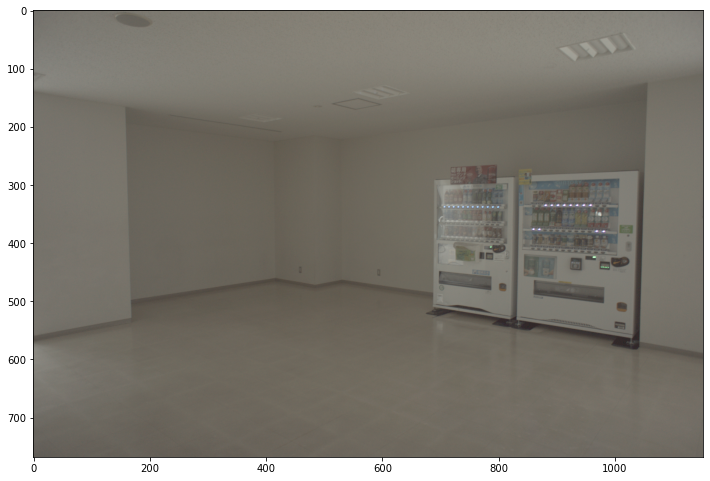

In [9]:
# 階調補正の実行関数
def tone_correction(input, func, params=None):
    # コントラスト補正の実行（速度は度外視）
    output = np.array([(255 * func(a / 255.0, params)).astype('uint8') for a in input]) 
    return output

# ガンマ補正関数
# gamma：γ値
def gamma_function(x, params):
    gamma = params
    return x ** (1/gamma)

# トーンカーブ・原画像・補正後画像の表示
def display_gamma_correction(corrected_img, gamma):
    # ここからトーンカーブの描画
    plt.figure(figsize=(16, 3))

    # トーンカーブの作成と描画
    ax = plt.subplot(1, 3, 1)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('input')
    ax.set_ylabel('output')
    x = np.arange(0.0, 1.0, 0.01)    # [0,1] の範囲で 0.01 刻みで入力配列作成
    y = gamma_function(x, gamma)  # 上記に対する出力配列の計算
    plt.plot(x, y)
    plt.title('Gamma correction (gamma={})'.format(gamma))

    # オリジナル画像の描画
    plt.subplot(1, 3, 2)
    plt.imshow(img, vmin = 0, vmax = 255)
    plt.title('before (gamma={})'.format(gamma))

    # ガンマ補正結果の表示
    plt.subplot(1, 3, 3)
    plt.imshow(corrected_img, vmin = 0, vmax = 255)
    plt.title('after (gamma={})'.format(gamma))

    plt.show()

gamma = 3.0
corrected_img = tone_correction(img, gamma_function, gamma) # ガンマ補正の実行
display_gamma_correction(corrected_img, gamma)

plt.figure(figsize=(12, 9))
plt.imshow(corrected_img)
plt.show()

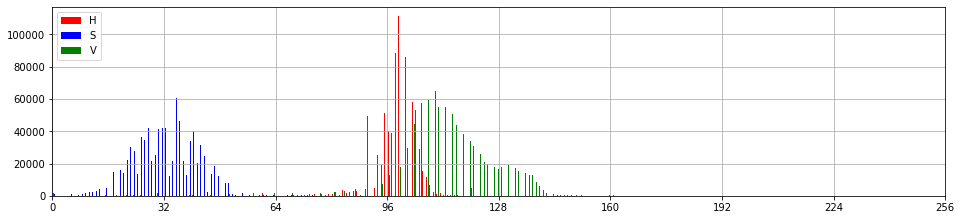

In [10]:
corrected_img_YUV = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2YUV)
corrected_img_HSV = cv2.cvtColor(corrected_img, cv2.COLOR_BGR2HSV)

# 画像を各色空間のプレーンごとに一次元の配列に成形
r = corrected_img[:, :, 2].flatten()
g = corrected_img[:, :, 1].flatten()
b = corrected_img[:, :, 0].flatten()

y = corrected_img_YUV[:, :, 0].flatten()
u = corrected_img_YUV[:, :, 1].flatten()
v = corrected_img_YUV[:, :, 2].flatten()

hue = corrected_img_HSV[:, :, 0].flatten()
saturation = corrected_img_HSV[:, :, 1].flatten()
value = corrected_img_HSV[:, :, 2].flatten()

bins_range = range(0, 256, 1)       # bins は [0,256)という指定になる（https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html）
xtics_range = range(0, 256 + 1, 32) # 目盛りを256まで表示させたいので 256 + 1 に設定しているだけ

plt.figure(figsize=(16, 16))

# (H,S,V)
plt.subplot(4, 1, 4)
plt.hist((hue, saturation, value), bins=bins_range, color=['r', 'b', 'g'], label=['H', 'S', 'V'])
plt.legend(loc=2) # 凡例の表示（loc=1: 右上，loc=2: 左上）
plt.grid(True)
[xmin, xmax, ymin, ymax] = plt.axis()
plt.axis([0, 256, 0, ymax])
plt.xticks(xtics_range)

plt.show()

---
### 3）画質の調整（例：鮮鋭化，ノイズ除去など）
#### 本処理の狙い
  * 本処理は色変換を行った後の画像について◎◎することを目的としている．
  * ここでは，？？という特徴を持った★★処理を適用する．

#### 結果と考察
  * 結果と考察を行う

In [11]:
# いったんコピーを取ってから処理を行う
filtered_img = img.copy()

# 何かしらの処理を施す
# 必要なパッケージのインポート
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt

class MyImage:
    def __init__(self, filepath):
        self.filepath = filepath
        
        # ファイルの読み込み
        self.original_img = cv2.imread(filepath)
        self.reload()
        
    def reload(self):
        self.img = self.original_img.copy()
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB) # BGR → RGB への変換
        return self.img
        
    def resize(self, size):
        self.img = cv2.resize(self.img, dsize=tuple(size[::-1]), interpolation=cv2.INTER_AREA)
        return self.img
    
    def get_grayscale(self):
        return cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)

    def img_info(self):
        print("*==============================================*")
        print(" 原画像情報")
        MyImage._img_info(self.filepath, self.original_img)
        print()
        print("*==============================================*")
        print(" 現在の状態")
        MyImage._img_info(self.filepath, self.img)

    # 画像の基本情報の獲得
    @classmethod
    def _img_info(cls, filepath, img):
        # パラメータの取得
        ndim  = img.ndim  # プレーン数
        shape = img.shape # (Height,Width,Planes)
        size  = img.size  # 全要素数（H x W x P）
        dtype = img.dtype # データ型

        h = shape[0] # 行（縦）
        w = shape[1] # 列（横）
        c = shape[2] # チャンネル

        print("*----------------------------------------------*")
        print(" ファイル名：",filepath)
        print(" プレーン数：",ndim)
        print(" サイズ　　：",shape)
        print("   縦（行）：",h)
        print(" 　横（列）：",w)
        print("   色　　　：",c)
        print(" 全要素数　：",size, end="")
        print(' （{} x {} x {} = {}）'.format(h, w, c, h*w*c)) # 書式付き文字列は format 関数で出力できる
        print(" データ型　：",dtype)
        print("*----------------------------------------------*")
    
    # カーネルを画像化
    #   kernel：カーネル
    #   fontSize: フォントサイズ
    @classmethod
    def kernel_img(cls, kernel, font_size=2.5, img_width=1024, img_height=1024):
        ks = kernel.shape
        kh = ks[0]
        kw = ks[1]

        iw = img_width
        ih = img_height
        img = np.tile(np.uint8([255,255,255]), (ih, iw, 1))

        bh = ih / kh
        bw = iw / kw

        # 値の描画
        for h in range(kh):
            for w in range(kw):
                px = int(bw / 4 + bw * w)
                py = int(bh / 1.75 + bh * h)
                font = cv2.FONT_HERSHEY_SIMPLEX
                #print("{:.1f}".format(kernel[h,w]))
                cv2.putText(img, "{:.2f}".format(kernel[h,w]), (px,py), font, font_size, (0,0,0), 2, cv2.LINE_AA);

        # 横線の描画
        for h in range(kh):
            if h > 0:
                lh = int(bh*h)
                cv2.line(img, (0, lh), (iw-1, lh), (0,0,0), 3)

        # 縦線の描画
        for w in range(kw):
            if w > 0:
                lw = int(bw*w)
                cv2.line(img, (lw, 0), (lw, ih-1), (0,0,0), 2)
        return img

---
以降，セルは適宜増やして用いること．

---
## 課題 1-2）「焦点ぼけとカメラぶれの補正」


### 課題の目的

* ここまでの講義で扱ってきた画像処理の理論を理解しているかの確認
* ここまでの講義で扱ってきたサンプルコードを理解し，必要な関数を用いて上記理論を実装できるかの確認

### 課題
関数 deteriorate() は以下の画像劣化を順にシミュレートしたものである．
1. 焦点ぼけ
1. カメラぶれ

上記，0-1）の入力画像として，まず Lenna 画像から自身で用意した画像に変更すること．その上で，以下のスクリプトで出力された画像 deteriorated_image の復元をし，その結果について考察せよ．<font color="red">**現画像に対する復元の定量的な目標値として「PSNR 30 dB以上」を目安とする．**</font>


ただし，カメラぶれの関数$h(x, y)$は以下のフィルタリング関数で近似できるとする．ただし，幅$w$とぶれの方向$\theta$は，図1で表されるカメラぶれの関数のイメージから推定せよ．

\begin{align*}
h(x, y) &= \left\{ \,
\begin{alignedat}{2}
&\frac{1}{w} & \qquad & \text{if}\ \left| x \cos \theta + y \sin \theta \right| \leq \frac{w}{2} \ \& \  x\sin \theta = y \cos \theta \\
&0  & \qquad & \text{otherwise}
\end{alignedat}
\right.
\end{align*}

<img src="./data/shake.png">
<center>図１：カメラぶれのモデル（信号空間での表現）</center>

### レポート作成に関する注意事項

　画像復元処理においては「画像処理を試してみた」ではなく，理系大学生のレポートとなるように特に以下のことに留意すること．

  1. 復元の方法について<font color="red">**理論式を記述する**</font>こと．例えば，以下は空間フィルタリングの例であるが，周波数フィルタリングを用いる場合はまた異なる理論式となるはずであり，復元の具体的な処理も数種類の手法が考えられる．
    * 例）空間フィルタリングで復元を行うことを考え，以下のフィルタ関数$h(x, y)$を直接推定する．ただし$g(x, y)$を劣化画像とし，$f(x, y)$を復元すべき原画像とする．
      \begin{equation}
      g(x, y) = f(x, y) * h(x, y)\\
      \end{equation}
      <br>
  1. 復元においては，焦点ぼけ，カメラぶれのそれぞれに関して劣化モデルを推定し，適用すること
    * 上記の理論式中における<font color="red">**劣化モデルを数式で**</font>具体的に表し，<font color="red">**パラメータの定量値に関しては推定した根拠を明示する**</font>こと．
    * 例えば，試行錯誤的にフィルタを設計した場合は，設計の根拠となった複数のモデル・パラメータを適用した結果も明示すること
      <br>
      <br>
  1. 考察においては復元結果の良し悪しを評価し，改善点があれば述べよ
    * 評価にあたっては（本来は存在しないが）オリジナルの画像を用いてもよい
    * 定性的な評価を含んでもよいが，<font color="red">**必ず 1 つは定量的な結果に基づく考察**</font>を加えること
      * ぼけの度合いの復元具合や画像同士の類似度などに関して，いくつかの指標が考えられる
      * ヒストグラムやプロファイル，PSNRなど講義中に説明したものやそれ以外に独自に調査したものを用いる

-----
### 必要なライブラリのインポートと画像の準備
  * 適宜，必要なライブラリを追加してよい

*==============================================*
 原画像情報
*----------------------------------------------*
 ファイル名： .\data\momo.png
 プレーン数： 3
 サイズ　　： (4032, 3024, 3)
   縦（行）： 4032
 　横（列）： 3024
   色　　　： 3
 全要素数　： 36578304 （4032 x 3024 x 3 = 36578304）
 データ型　： uint8
*----------------------------------------------*

*==============================================*
 現在の状態
*----------------------------------------------*
 ファイル名： .\data\momo.png
 プレーン数： 3
 サイズ　　： (2016, 1512, 3)
   縦（行）： 2016
 　横（列）： 1512
   色　　　： 3
 全要素数　： 9144576 （2016 x 1512 x 3 = 9144576）
 データ型　： uint8
*----------------------------------------------*


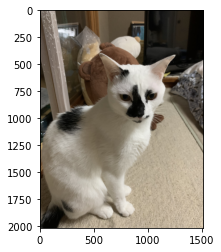

In [12]:
from deteriorate import *

#=======================================
# 変更するパラメータ
#=======================================
# ディレクトリ名
data_dirname = "data" # 入力データのディレクトリ
out_dirname  = "out"  # 出力データのディレクトリ

# ファイル名
input_filename = "momo.png" # ここを自分で用意した画像に変えること
resized_ratio  = 0.5           # リサイズ後の画像の比率 [0, 1]
#=======================================

def prepare(filepath, ratio):
    image = MyImage(filepath)

    # リサイズ処理
    org_size = np.array(image.img.shape[:2]) # （縦，横）のみ取得
    out_size = (org_size * ratio).astype(int)
    _ = image.resize(out_size)
    image.img_info()
    return image

filepath = os.path.join('./', data_dirname, input_filename).replace('/', os.sep)
image = prepare(filepath, resized_ratio)

plt.figure(figsize=(4,4))
plt.imshow(image.img)
plt.show()

### 画像復元のための関数の定義

1. inverse_deconvolution(efks, unshifted_spec, epsilon = 0.5)
  * 逆フィルタ（inverse filter）
\begin{align*}
K_{\text{inv}}(u, v) &= 1 / H'(u, v) \\
H'(u, v) &= \left\{ \,
\begin{alignedat}{2}
&\epsilon & \qquad & \text{where}\ \left|H(u, v)\right| < \epsilon \\
&H(u, v)  & \qquad & \text{otherwise}
\end{alignedat}
\right.
\end{align*}
<br>
1. winer_deconvolution(efks, unshifted_spec, gamma = 0.001)
  * ウィーナフィルタ（Wiener filter）
\begin{align*}
K_{\text{w}}(u, v) &= \frac{1}{H(u, v)}\frac{\left| H(u, v) \right|^2}{\left| H(u, v) \right|^2 + \Gamma} = \frac{H^{*}(u, v)}{\left| H(u, v) \right|^2 + \Gamma} \\
\Gamma &= \frac{\left| N(u, v) \right|^2}{\left| F(u, v) \right|^2}
\end{align*}
<br>
1. deconvolution(estimated_filter_kernel, unshifted_spec, deconv_func, param = None, explain=None)：デコンボリューションの実行
    * estimated_filter_kernel：推定したカーネル
    * unshifted_spec：復元したい画像の周波数スペクトル（fftshift していない状態）
    * deconv_func：復元処理のフィルタ関数（以下の inverse_deconvolution または winer_deconvolution）
    * param：復元時のフィルタに渡すパラメータ
      * inverse_deconvolution：$\epsilon$（epsilon）の値
      * winer_deconvolution：$\Gamma$（gamma）の値
    * explain：表示される図につける説明文
<br>
<br>
1. camera_shake_kernel(hh, hw, W, theta)：カメラぶれのフィルタカーネル
    * hh：カーネル高さ
    * hw：カーネル幅
    * W：カメラぶれ幅 $w$
    * Theta：カメラぶれ方向 $\theta$
\begin{align*}
h(x, y) &= \left\{ \,
\begin{alignedat}{2}
&\frac{1}{w} & \qquad & \text{if}\ \left| x \cos \theta + y \sin \theta \right| \leq \frac{w}{2} \ \& \  x\sin \theta = y \cos \theta \\
&0  & \qquad & \text{otherwise}
\end{alignedat}
\right.
\end{align*}
<br>
1. PSNR(img0, img1)：PSNR（Peak Noise-to-Noise Ratio）の計算
    * img0：比較画像1枚目
    * img1：比較画像2枚目
\begin{align*}
\mathrm{PSNR} &= 10 \log_{10}{\frac{255^2}{\mathrm{MSE}}} \\
\mathrm{MSE} &= \frac{1}{MN}\sum_{y=0}^{M-1} \sum_{x=0}^{N-1}\left\{f_1(x, y) - f_2(x, y)\right\}^2
\end{align*}
<br>
<br>
1. gaussian_kernel(ksize): 自作ガウシアンカーネル
  * ksize: カーネルサイズ

In [13]:
def inverse_deconvolution(unshifted_efks, unshifted_spectrum, epsilon=0.5):
    unshifted_efks_copy = unshifted_efks.copy()
    
    target = np.abs(unshifted_efks_copy) < epsilon
    unshifted_efks_copy[target] = np.sign(unshifted_efks_copy[target]) * epsilon
    unshifted_efks_copy[unshifted_efks_copy == 0] = epsilon
    unshifted_efks_inv = 1 / unshifted_efks_copy
    unshifted_restored_spectrum = unshifted_spectrum * unshifted_efks_inv

    return unshifted_restored_spectrum

def winer_deconvolution(unshifted_efks, unshifted_spectrum, gamma=0.001):
    unshifted_restored_spectrum = unshifted_spectrum * np.conjugate(unshifted_efks)/ (np.abs(unshifted_efks)**2 + gamma)  
    return unshifted_restored_spectrum

def deconvolution(estimated_filter_kernel, unshifted_spectrum, deconv_func, param=None, explain=None):
    h, w = unshifted_spectrum.shape[:2]
    r, c = estimated_filter_kernel.shape[:2]

    kernel_img = np.zeros((h, w), np.float32)
    kernel_img[0:r,0:c] = estimated_filter_kernel

    # estimated filter kernel spectrum (efks)
    efks = np.fft.fft2(kernel_img)
    shifted_efks = np.fft.fftshift(efks)
    shifted_efks4show = MyImage.normalize_spectrum(shifted_efks, shifted=True)
    
    # deconvolution
    if param is not None:
        restored_spectrum = deconv_func(efks, unshifted_spectrum, param)
    else:
        restored_spectrum = deconv_func(efks, unshifted_spectrum)        
    restored_spectrum4show = MyImage.normalize_spectrum(restored_spectrum, shifted=False)
    
    fig = plt.figure(figsize=(12,9))
    
    plt.subplot(121)
    plt.imshow(shifted_efks4show, cmap="gray", interpolation="gaussian")
    plt.title("spectrum of estimated filter kernel")
    
    plt.subplot(122)
    plt.imshow(restored_spectrum4show, cmap="gray")
    plt.title("spectrum of deconvoluted image")
    
    restored_img = np.fft.ifft2(restored_spectrum)
    restored_img = np.abs(restored_img).astype('uint8')

    fig = plt.figure(figsize=(5.6,5.6))
    plt.subplot(111)
    plt.imshow(restored_img, cmap="gray")
    title_suffix = ""
    if explain is not None:
        title_suffix = " ({})".format(explain)
    plt.title("deconvoluted image{}".format(title_suffix))
    
    return restored_img, restored_spectrum

def camera_shake_kernel(hh, hw, w, theta):
    hxy_shake = np.full((hh, hw), 0, dtype=np.float32)

    cy, cx = np.floor(hh / 2.0), np.floor(hw / 2.0)
    theta = -theta
    for y in range(hh):
        for x in range(hw):
            _x = x - cx
            _y = cy - y
            if (np.abs((_x*np.cos(theta) + _y*np.sin(theta))) <= (w / 2.0)) \
            and (np.round(np.abs(_x*np.sin(theta) - _y*np.cos(theta))) == 0):
                hxy_shake[y,x] = 1 / w
            else:
                hxy_shake[y,x] = 0    
    
    return hxy_shake

def PSNR(img0, img1):
    MSE = np.mean((img0 - img1) ** 2)
    if MSE == 0:
        return 999
    PIXEL_MAX = 255.0
    return 10 * np.log10(PIXEL_MAX * PIXEL_MAX / MSE)


# 正規分布
def norm2d(X, Y, sigma):
    Z = np.exp(-(X**2 + Y**2) / (2 * sigma**2)) / (2 * np.pi * sigma**2)
    return Z


# 自作ガウスカーネル
# カーネルサイズ K = 2w + 1の場合，sigma = w/2 とする
def gaussian_kernel(ksize):
    if ksize%2==0:
        print('kernel size should be odd')
        return
    sigma = (ksize - 1)/2
    
    # [0,size]→[-sigma, sigma] にずらす
    x = y = np.arange(0, ksize) - sigma
    X, Y = np.meshgrid(x, y) 
    mat = norm2d(X, Y, sigma)
    
    kernel = mat / np.sum(mat)
    return kernel

-----
### 劣化画像の出力

以下のスクリプトを実行すると劣化画像が生成されます．各関数・各変数の意味は以下の通り．
1. deteriorate(src)：画像を劣化させる関数
  * src：オリジナルの画像
  * 戻り値：劣化させた画像
<br>
1. original_image：グレイスケール化したオリジナル画像
<br>
1. deteriorated_image：劣化後の画像（この画像を補正してオリジナル画像を復元する）

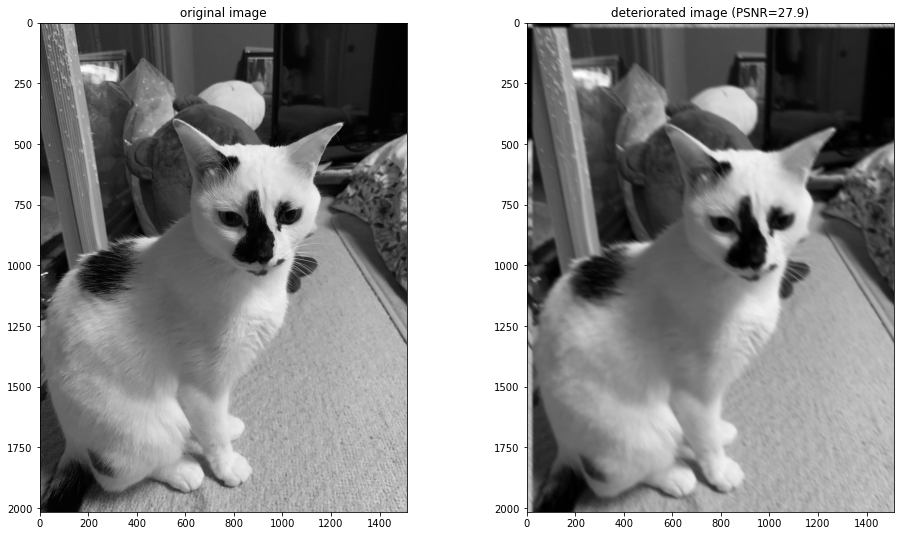

In [14]:
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# 劣化画像を出力するスクリプト
#=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

# オリジナル画像
original_image = image.get_grayscale()

# 画像の劣化
deteriorated_image = deteriorate(original_image) # ← この画像（deteriorated_image）を補正せよ

plt.figure(figsize=(16, 9))

plt.subplot(121)
plt.imshow(original_image, cmap="gray")
plt.title("original image")

plt.subplot(122)
plt.imshow(deteriorated_image, cmap="gray")
plt.title("deteriorated image (PSNR={:.3})".format(PSNR(original_image, deteriorated_image)))

plt.show()

---
##  課題 1-2）解答用紙

以降，セルは適宜増やして用いること．

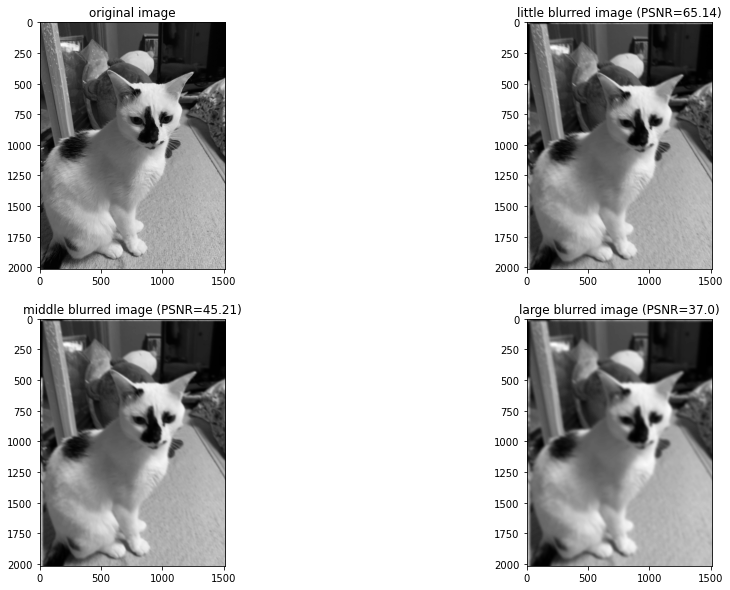

In [15]:
def PSNR(img0, img1):
    MSE = np.mean((img0 - img1) ** 2)
    if MSE == 0:
        return 999
    PIXEL_MAX = 255.0
    return 10 * np.log10(PIXEL_MAX * PIXEL_MAX / MSE)

# グレイスケール画像の獲得
original_img = image.get_grayscale()

small_blurred_img  = cv2.GaussianBlur(deteriorated_image, (3, 3), 0)
middle_blurred_img = cv2.GaussianBlur(deteriorated_image, (11, 11), 10)
large_blurred_img  = cv2.GaussianBlur(deteriorated_image, (25, 25), 20)

plt.figure(figsize=(16,10))

plt.subplot(221)
plt.imshow(original_img, cmap='gray')
plt.title("original image")

plt.subplot(222)
plt.imshow(small_blurred_img, cmap='gray')
plt.title("little blurred image (PSNR={:.4})".format(PSNR(small_blurred_img, deteriorated_image)))

plt.subplot(223)
plt.imshow(middle_blurred_img, cmap='gray')
plt.title("middle blurred image (PSNR={:.4})".format(PSNR(middle_blurred_img, deteriorated_image)))

plt.subplot(224)
plt.imshow(large_blurred_img, cmap='gray')
plt.title("large blurred image (PSNR={:.4})".format(PSNR(large_blurred_img, deteriorated_image)))

plt.show()

---
## 課題 1-3)「パノラマ画像合成」
    
### 課題の目的

* ここまでの講義で扱ってきた画像処理の理論を理解しているかの確認
* ここまでの講義で扱ってきたサンプルコードを理解し，必要な関数を用いて上記理論を実装できるかの確認

### 課題
第6回目の講義で扱ったパノラマ画像合成手法について

  1. 講義では2視点のみを扱ったが，この手法を3視点以上の任意の視点数で実行可能なように拡張して，その実行結果を示せ．ただし，用いる画像は自身で撮影すること．
  1. １．の複数視点に拡張したパノラマ画像の問題点を上げて解決せよ．ただし，少なくとも以下の2点の課題は解決すること
    * 共通部分と非共通部分で色の濃淡が生じている
    * 非表示領域の黒枠が大きく残ってしまっている

【注意事項】
  * 本課題の目的は画像処理のアルゴリズム構築と，その処理の理論的な記述法の習得（訓練）であることを理解して取り組むこと．
  * したがって，<font color="red">**cv2.sticher 関数をはじめ，直接的なパノラマ画像合成の機能を提供しているライブラリ群の使用は認めない**</font>．ただし，画像の入出力，対応点検出や幾何学的変換に関してはOpenCVの関数を用いてよい


---
##  課題 1-3）解答用紙

以降，セルは適宜増やして用いること．